# Task 2: Recommendation Engine

All our functions can be found in src/task2_preprocessing.py

## Setting up the Notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd

from pathlib import Path
from src.utils import missing_values_table, get_nearest_y, get_nearest_distances, save_fig
from src.preprocessing import clean_property_type, clean_tenure, read_dataframe, fill_missing_values, encode_and_bind
from src.task2_preprocessing import *

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [4]:
# create a folder for plots
os.makedirs("images", exist_ok=True)

In [5]:
data_dir = Path("../raw_data")
clean_data_dir = Path("../clean_data")
img_dir = Path("images")

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

## Load the Data


In [8]:
df_train_eda = pd.read_csv(Path(clean_data_dir, "df_train_eda.csv"), index_col=0)
df_raw = pd.read_csv(Path(data_dir, "train.csv"))
df_aux = pd.read_csv(Path(data_dir, "train_auxiliary_data.csv"), index_col=0)
df_mrt = pd.read_csv(Path(data_dir, "auxiliary-data", "sg-mrt-stations.csv"))
df_add_mrt_coord = pd.read_csv(Path(data_dir, "additional-data", "mrt_lrt_data.csv"))

## Merging MRT Information

- Using the mrt auxiliary information, we found the nearest mrt station for each listing.
- We mapped the nearest mrt station to the main data that we are using - ``df_train_eda``

In [9]:
df_train_eda_full = merge_mrt_info(df_mrt, df_raw, df_aux, df_train_eda)

In [10]:
df_train_eda_full.head()

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price,nearest_mrt
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb,99-year leasehold,1988,3.0,2.0,1115,116.000000,https://www.99.co/singapore/hdb/866-yishun-str...,1.414399,103.837196,0,yishun south,yishun,514500.0,khatib
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992,4.0,2.0,1575,375.188982,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,0,serangoon north,serangoon,995400.0,kovan
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022,4.0,6.0,3070,56.000000,https://www.99.co/singapore/condos-apartments/...,1.298773,103.895798,0,mountbatten,marine parade,8485000.0,dakota
3,857699,3 bed condo for sale in leedon green,26 leedon heights,leedon green,condo,freehold,2023,3.0,2.0,958,638.000000,https://www.99.co/singapore/condos-apartments/...,1.312364,103.803271,0,farrer court,bukit timah,2626000.0,farrer road
4,216061,2 bed condo for sale in one bernam,1 bernam street,one bernam,condo,99-year leasehold,2026,2.0,1.0,732,351.000000,https://www.99.co/singapore/condos-apartments/...,1.273959,103.843635,0,anson,downtown core,1764000.0,tanjong pagar


## Dropping columns that are not useful

- From the exploratory data analysis done in task 1, we have seen that ``Elevation`` is a constant column so we will also drop it.
- We feel that users will not consider information such as ``property_details_url`` and ``total_num_units`` when they are making a purchase so we will drop those. 
- We will also drop ``subzone`` and ``planning_area`` since we are going to use ``nearest_mrt`` as our main location identifier

In [11]:
cols_to_drop = ["property_details_url", "total_num_units", "subzone", "elevation", "planning_area"]
df_train_eda_full = df_train_eda_full.drop(cols_to_drop, axis=1)

## Features Transformation

To enhance user's experience when looking for a flat, we decided to categorize some key features that we believe users will have a preference over. We looked at the distribution of these features to decide on a suitable binning category.

- **built_year**: ``built_year`` contains units for future sale (those beyond current year). We could create another column to indicate whether this is a resale or new sale so that our users can select their preference. 
- **price**: We feel that when looking for a flat, a user would most likely have a budget in mind. Hence, we decided to split the ``price`` into different bins so that it is more convenient for them. We used the summary statistics to decide on the range to bin.
- **size_sqft**: Similar to price, we also split the ``size_sqft`` into different bins.
- **remaining_lease**: For HDB with 99 year leasehold, buyers usually want to take into account the remaining lease. We create ``remaining_lease`` by calculating the number of lease years remaining. For non-HDB, their value will be *Non-HDB* since there is no remaining lease for non-HDBs

We will keep the uncateogrized features as they contain a more accurate information for the users

In [12]:
df_train_eda_full = cat_sales_type(df_train_eda_full)
df_train_eda_full = cat_price(df_train_eda_full)
df_train_eda_full = cat_size(df_train_eda_full)
df_train_eda_full = cat_lease(df_train_eda_full)
df_train_eda_full.head()

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,price,nearest_mrt,sales_type,price_cat,size_cat,remaining_lease,lease_cat
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb,99-year leasehold,1988,3.0,2.0,1115,1.414399,103.837196,514500.0,khatib,Resale,500K-700K,Below 2000,65,60-70
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992,4.0,2.0,1575,1.372597,103.875625,995400.0,kovan,Resale,Above 900K,Below 2000,69,60-70
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022,4.0,6.0,3070,1.298773,103.895798,8485000.0,dakota,Resale,Above 900K,2000-5000,999,Non-HDB
3,857699,3 bed condo for sale in leedon green,26 leedon heights,leedon green,condo,freehold,2023,3.0,2.0,958,1.312364,103.803271,2626000.0,farrer road,New,Above 900K,Below 2000,999,Non-HDB
4,216061,2 bed condo for sale in one bernam,1 bernam street,one bernam,condo,99-year leasehold,2026,2.0,1.0,732,1.273959,103.843635,1764000.0,tanjong pagar,New,Above 900K,Below 2000,999,Non-HDB


## Methodology

Our approach is as follows:   

**1. New user**
- When users first "use" our recommendation system, we do not know what the users are interested in. Thus, we will first have them input their preferred location since we believe location is one of their top consideration when looking for a flat.
- There could be instances where our listings do not contain their preferred location. To account for such situation, we will perform KMeans clustering on the latitude and longitude to look for nearby units that are close to their preferred location.
- After filtering the location, we will ask the user to input their preferred sales_type (new or resale), price range, size range, number of bedrooms, number of bathrooms and lease category. We then compute the cosine similarity of this encoded dataframe. We will then show them the top K listings according to the cosine similarity score.

**2. Keeping track of user's history**
- After users are shown the top listings based on their preference, we will start keeping track of theirbrowsing history by storing the ``listing_id`` of browsed listings. Since we have no way to know what they have browsed, we will just randomly pick an index from what they were shown and treat it as their browsed listing. 

**3. Identify similar listings**
- Using their browsing history together with their preference, we will identify similar listings based on the cosine similarity score.

## Location filter

As mentioned in our methodology, we believe that the location is one of the top consideration for users when looking for a flat. As such, we don't want to just limit them to what they indicate. We want to also show them nearby listings for their consideration. 

We chose the number of cluster based on the size of each cluster. The size shouldn't be too big as we want to make sure we only consider units that are nearby the preferred location of the user. The size also should'nt be too small as we want to give our users more options. After experimenting, we found 10 clusters to be ideal.

Saving figure kmeans_location


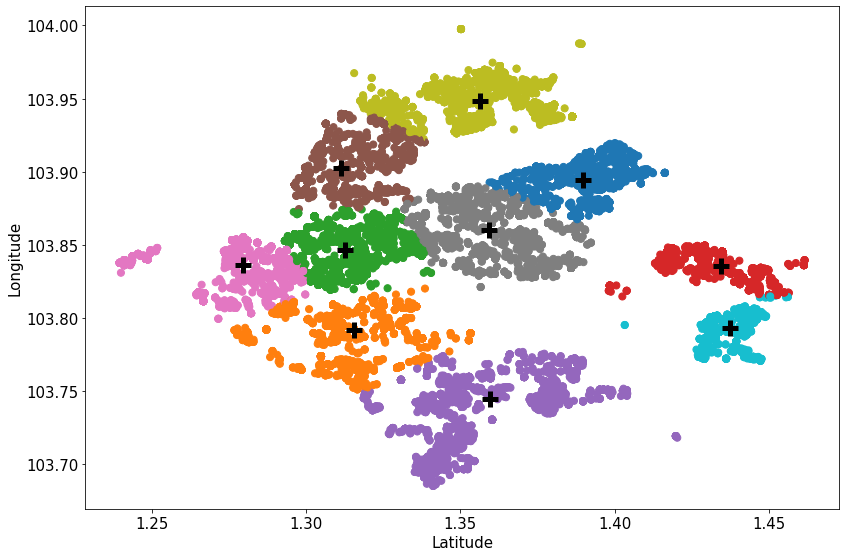

In [13]:
df_recommend_full = df_train_eda_full.copy()
df_lat_lng_full = df_recommend_full.loc[:,["lat", "lng"]]
kmeans = KMeans(n_clusters=10, random_state=0).fit(df_lat_lng_full)
plot_clusters(kmeans, df_lat_lng_full, "Longitude", "Latitude", img_dir)

- After deciding on the number of clusters, we will proceed to create our ``filtered_location`` function which takes the user's preferred location and returns nearby listings. ``filtered_location`` is found in ``task2_preprocessing.py``

## User's Preference

Users have to input their following preferences based on the following selections. As mentioned, we looked at the distribution of the features to decide on the binning category.
- **preferred_sales_type**: "Resale", "New"  
- **preferred_price_cat**: "Below 300K", "300K-500K", "500K-700K", "700K-900K", "Above 900K"  
- **preferred_size_cat**: "Below 2000", "2000-5000", "5000-8000", "8000-10000", "Above 10000"
- **preferred_num_beds**: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
- **preferred_num_baths**: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
- **preferred_remaining_lease**: "Below 60", "60-70", "70-80", "80-90", "90-99", "Non-HDB"

We created a ``preference`` function that takes in the user's preferences. ``preference`` is found in ``task2_preprocessing.py``

## Encoding

In order to compute the cosine similarity score, we have to first encode our dataframe. We use one hot encoding here as cosine similarity is beneficial for applications that utilizes sparse data and shouldn't be a problem for our purpose. We created a ``encode`` function to one hot encode the data. ``encode`` is found in ``task2_preprocessing.py``

## Similarity Matrix

We created a ``similarity_matrix`` function that computes the cosine similarity of the encoded data. ``similarity_matrix`` is found in ``task2_preprocessing.py``

## Identify Top Listings

For new user, we are only interested in the similarity between the user's preference (inputted in the beginning) with respect to other listings so we will only take the a subset of the cosine similarity matrix. For example, for a new user, he will input one set of preference. We have already appended his preference to the main listings dataset before calculating the similarity index. Since there is only one set of preference and the appended preference will appear as the last row in the similarity matrix, we will only be looking at the last row.

For user's browsed history later on, depending on the number of listings the user browsed, we will be looking at more than one row. In addition, since it is also possible that a particular listing appear more than once as the recommended listings, we will take the average similarity.

We created a ``identify_top_listings`` function that takes in the main data where recommendations are obtained from, the cosine similarity matrix, the number of recommended listings as well as the number of preferences.

``identify_top_listings`` is found in ``task2_preprocessing.py``



## Keeping track of user's browsing history

We created a function ``store_browsing_history`` that takes in a list of browsed listings and the dataframe that was shown to the user.
- Since we have no idea which listing the user will click, we just randomly generate a number and assumed that the user clicked on that listing.

``store_browsing_history`` is found in ``task2_preprocessing.py``

## Browsing history recommnedation

As we do not want to limit the number of choices to just the user's stated preferences, we took into account their browsed history and also recommend them listings that are similar to their browsed history.

Since we want to give our users selections beyond their preferred cluster (location), we will recommend more listings based on their browsing history. For example, if the user entered a location that is from cluster 2, browsed a listing, then entered location from cluster 4 and browsed a listing, if the user enters another location from cluster 6, we will not only show him listings from cluster 6 but also similar listings from cluster 2 and 4.

We created a ``browsing_history_recommendation`` function to identify similar listings that are outside of their preferred cluster based on their browsing history.

``browsing_history_recommendation`` is found in ``task2_preprocessing.py``

## Recommendation

Here, we put together all the building blocks and present our final recommendation system!

In [24]:
def get_top_recommendations(df_recommend_full, pref_location, pref_sales_type, pref_price_cat, pref_size_cat, pref_num_beds, 
                            pref_num_baths, pref_lease_cat, top_recommend_num):

    # filter select based on location
    df_recommend_full_cluster, df_location, new_point_cluster = filtered_location(df_recommend_full, df_add_mrt_coord, pref_location)
    
    # user's preference
    df_pref = preference(pref_sales_type, pref_price_cat, pref_size_cat, pref_num_beds, pref_num_baths, pref_lease_cat, new_point_cluster) 
    
    # one hot encode user's preference and add to the main df_location dataframe
    df_encode = encode(df_location, df_pref)
    
    # get cosine similarity score
    sim_matrix = similarity_matrix(df_encode)
    
    # identify top listings
    df_top_listings = identify_top_listings(df_location, sim_matrix, top_recommend_num, df_pref.shape[0])

    # show users only default information
    #df_top_listings = df_top_listings.drop(["sales_type", "price_cat", "size_cat", "remaining_lease", "lease_cat"], axis=1)
    # sort listings based on similarity score
    df_top_listings = df_top_listings.sort_values(by="sim_score", ascending=False)
    
    # assume user clicked on the some random listing
    browsed_listings = store_browsing_history(browsed_list, df_top_listings)
    
    # in the event there are duplicates in the browsed_listings, remove it
    browsed_listings = list(set(browsed_listings))
    
    # we fixed the number of recommendation for browsed history to 10 to give users sufficient choices
    # beyond what they inputted (find similar listings not subjected to location)
    df_top_browsed_listings = browsing_history_recommendation(browsed_listings, df_recommend_full_cluster, 10)

    # finally, we will group all the top listings into one final dataframe
    df_final_recommended_listings = df_top_listings.append(df_top_browsed_listings)
    df_final_recommended_listings = df_final_recommended_listings.sort_values(by="sim_score", ascending=False)
    
    # remove duplicated listings
    df_final_recommended_listings = df_final_recommended_listings.drop_duplicates()
    
    # show top 10 listings
    df_final_recommended_listings = df_final_recommended_listings.head(top_recommend_num)
    return df_final_recommended_listings


## Testing the Recommendation Engine

In [25]:
# list to store all browsed listings (do not re run this cell when 
# testing as we want to keep all the "browsed" listings)
browsed_list = []

Users have to input these choices when testing out the recommendation engine

- **preferred_location**: A valid MRT station name. If invalid, exception raised.
- **preferred_sales_type**: "Resale", "New"  
- **preferred_price_cat**: "Below 300K", "300K-500K", "500K-700K", "700K-900K", "Above 900K"  
- **preferred_size_cat**: "Below 2000", "2000-5000", "5000-8000", "8000-10000", "Above 10000"
- **preferred_num_beds**: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
- **preferred_num_baths**: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
- **preferred_remaining_lease**: "Below 60", "60-70", "70-80", "80-90", "90-99", "Non-HDB"

Feel free to run the function multiple times to see different results

In [26]:
df_final_recommended_listings = get_top_recommendations(df_recommend_full, 
                                                            pref_location="Jurong East", 
                                                            pref_sales_type="Resale", 
                                                            pref_price_cat= "500K-700K", 
                                                            pref_size_cat="Below 2000", 
                                                            pref_num_beds=3, 
                                                            pref_num_baths=2, 
                                                            pref_lease_cat="80-90", 
                                                            top_recommend_num=5)

In [28]:
df_final_recommended_listings = get_top_recommendations(df_recommend_full, 
                                                            pref_location="tampines", 
                                                            pref_sales_type="Resale", 
                                                            pref_price_cat= "500K-700K", 
                                                            pref_size_cat="Below 2000", 
                                                            pref_num_beds=3, 
                                                            pref_num_baths=2, 
                                                            pref_lease_cat="80-90", 
                                                            top_recommend_num=5)

In [30]:
df_final_recommended_listings = get_top_recommendations(df_recommend_full, 
                                                            pref_location="woodlands", 
                                                            pref_sales_type="Resale", 
                                                            pref_price_cat= "Below 300K", 
                                                            pref_size_cat="Below 2000", 
                                                            pref_num_beds=3, 
                                                            pref_num_baths=2, 
                                                            pref_lease_cat="80-90", 
                                                            top_recommend_num=5)

In [32]:
df_final_recommended_listings

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,price,nearest_mrt,sales_type,price_cat,size_cat,remaining_lease,lease_cat,cluster,sim_score
502,570027,hdb flat for sale in 348d yishun avenue 11,sembawang / yishun (d27),adora green,hdb,99-year leasehold,2013,3.0,2.0,990,1.427086,103.842788,753900.0,yishun,Resale,700K-900K,Below 2000,90,80-90,5,0.8
16857,862524,hdb flat for sale in 185 bedok north road,bedok / upper east coast (d16),vista 8,hdb,99-year leasehold,2005,3.0,2.0,990,1.326221,103.940814,661500.0,tanah merah,Resale,500K-700K,Below 2000,82,80-90,7,0.8
11644,662291,hdb flat for sale in 675a jurong west street 64,boon lay / jurong / tuas (d22),[email protected],hdb,99-year leasehold,2008,3.0,2.0,979,1.345434,103.703541,525000.0,boon lay,Resale,500K-700K,Below 2000,85,80-90,6,0.8
13382,758977,hdb flat for sale in 182 bedok north road,bedok / upper east coast (d16),vista 8,hdb,99-year leasehold,2006,3.0,2.0,915,1.326934,103.941658,651000.0,tanah merah,Resale,500K-700K,Below 2000,83,80-90,7,0.8
917,580300,hdb flat for sale in 348a yishun avenue 11,sembawang / yishun (d27),adora green,hdb,99-year leasehold,2013,3.0,2.0,990,1.427451,103.841356,682500.0,yishun,Resale,500K-700K,Below 2000,90,80-90,5,0.8
